# **Quantization**

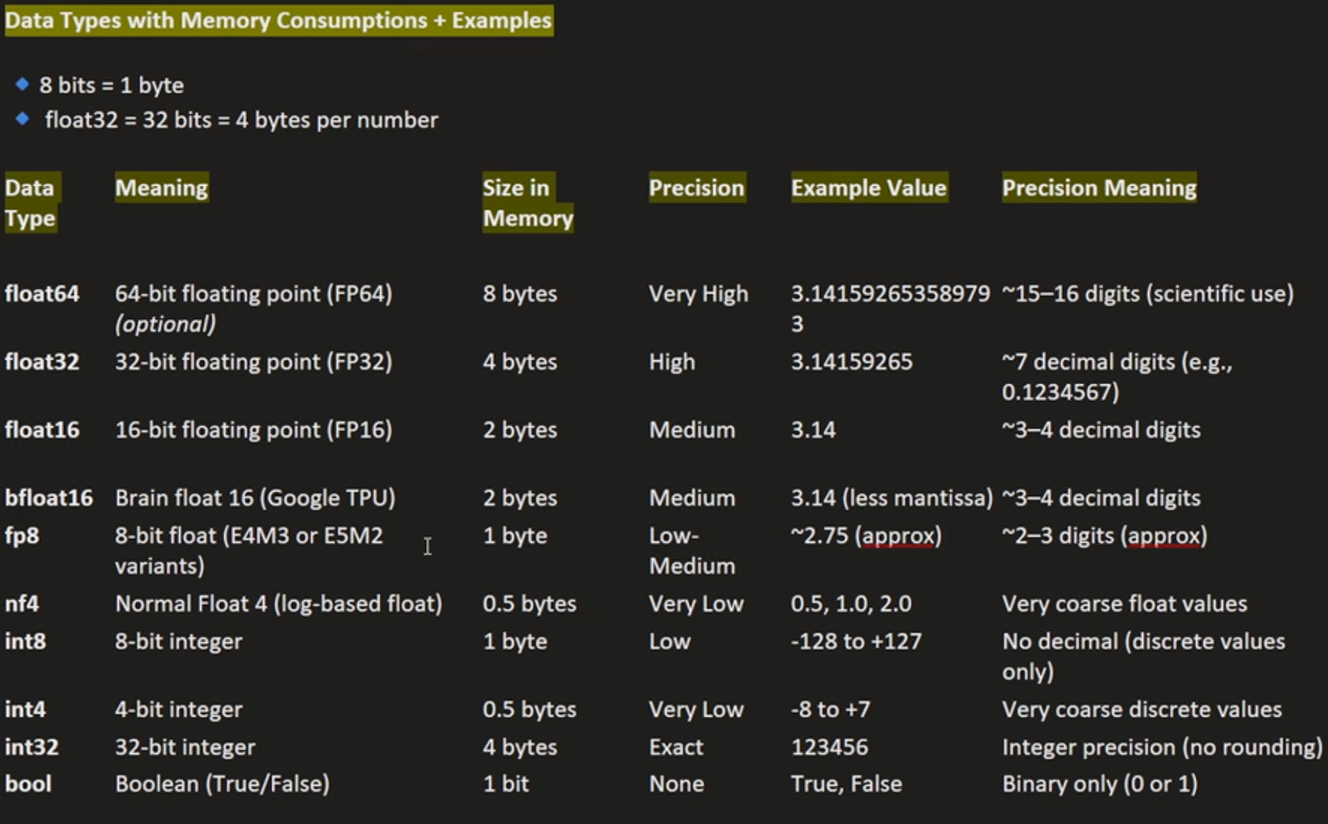

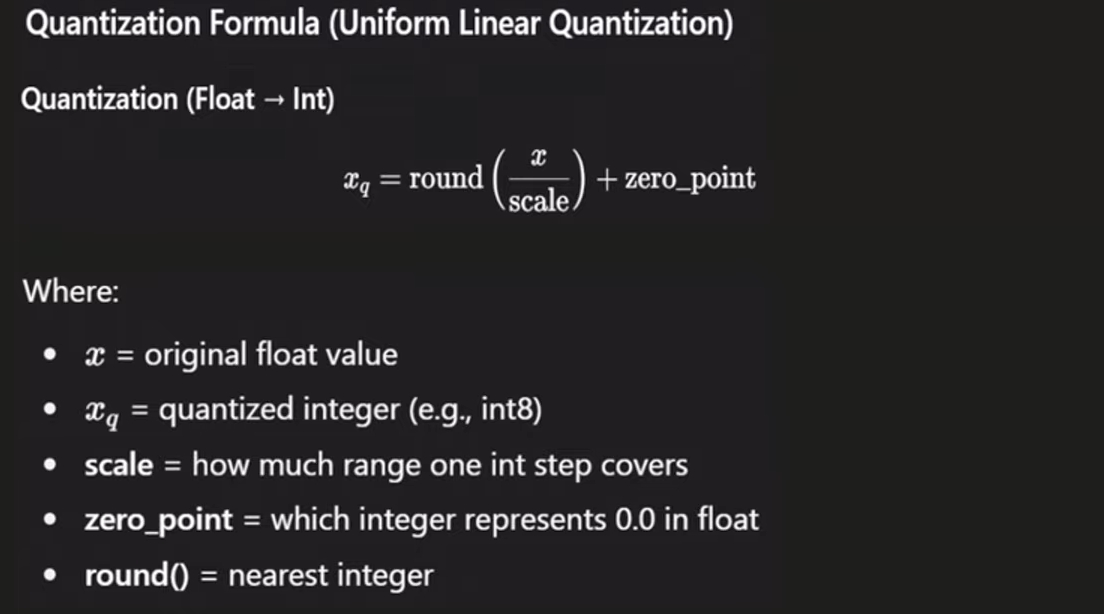

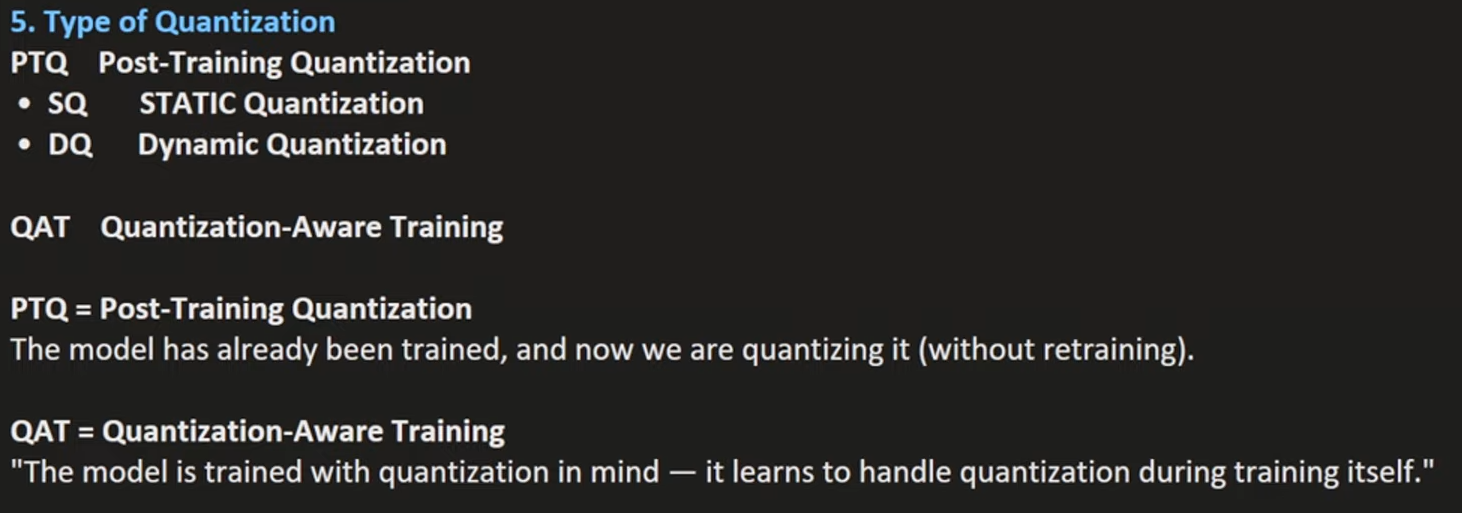

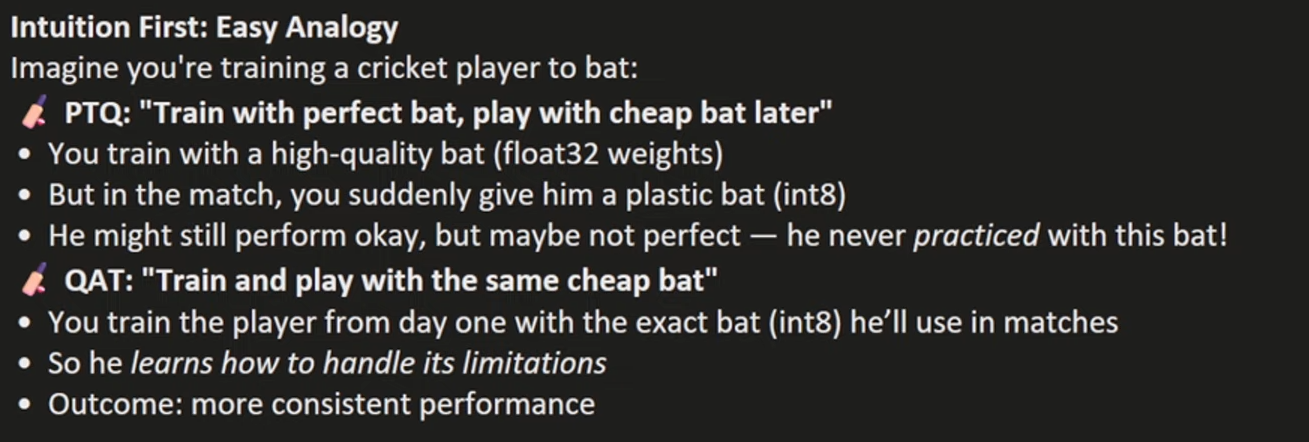

- GPTQ = Gradient Post Training Quantization
- AWQ  = Activation Aware Quantization

## **Post-Training Quantization (PTQ)**

### **PTQ (Dynamic)**

- Weights: Quantized manually (INT8)
- Activations: Not touched at all (still in FP32)
- Calibration: Does not happen

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as functional
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

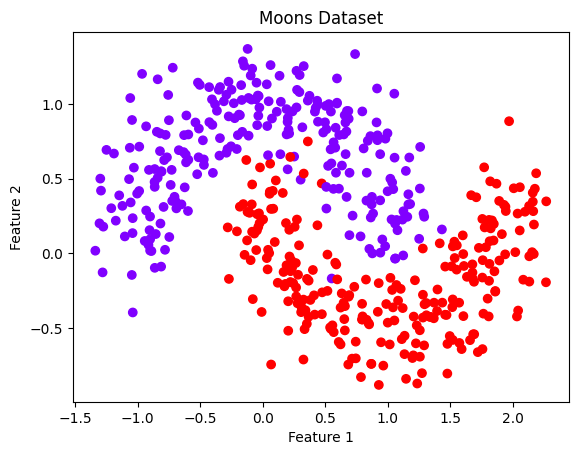

In [ ]:
x, y = make_moons(n_samples=500, shuffle=True, noise=0.2, random_state=123)
plt.scatter(x[:, 0], x[:, 1], c=y, cmap='rainbow')
plt.title("Moons Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

In [ ]:
x, y = make_moons(n_samples=1000, shuffle=True, noise=0.2, random_state=123)

In [ ]:
scaler = StandardScaler()
x = scaler.fit_transform(x)
x = torch.tensor(x, dtype=torch.float32)

y = y.reshape(-1, 1)
y = torch.tensor(y, dtype=torch.float32)

In [ ]:
print(f"X shape: {x.shape}")
print(f"Y shape: {y.shape}")

X shape: torch.Size([1000, 2])
Y shape: torch.Size([1000, 1])


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)

In [ ]:
print(f"X train shape: {x_train.shape}")
print(f"Y train shape: {y_train.shape}")
print(f"X test shape: {x_test.shape}")
print(f"Y test shape: {y_test.shape}")

X train shape: torch.Size([800, 2])
Y train shape: torch.Size([800, 1])
X test shape: torch.Size([200, 2])
Y test shape: torch.Size([200, 1])


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(2, 256)
    self.fc2 = nn.Linear(256, 128)
    self.fc3 = nn.Linear(128, 64)
    self.fc4 = nn.Linear(64, 32)
    self.fc5 = nn.Linear(32, 16)
    self.fc6 = nn.Linear(16, 1)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.relu(self.fc4(x))
    x = F.relu(self.fc5(x))
    x = torch.sigmoid(self.fc6(x))
    return x

fp32_model = MLP()

In [ ]:
for name, p in fp32_model.named_parameters():
  print(f"Parameter name: {name}, Shape: {p.shape}, Requires grad: {p.requires_grad}")

Parameter name: fc1.weight, Shape: torch.Size([256, 2]), Requires grad: True
Parameter name: fc1.bias, Shape: torch.Size([256]), Requires grad: True
Parameter name: fc2.weight, Shape: torch.Size([128, 256]), Requires grad: True
Parameter name: fc2.bias, Shape: torch.Size([128]), Requires grad: True
Parameter name: fc3.weight, Shape: torch.Size([64, 128]), Requires grad: True
Parameter name: fc3.bias, Shape: torch.Size([64]), Requires grad: True
Parameter name: fc4.weight, Shape: torch.Size([32, 64]), Requires grad: True
Parameter name: fc4.bias, Shape: torch.Size([32]), Requires grad: True
Parameter name: fc5.weight, Shape: torch.Size([16, 32]), Requires grad: True
Parameter name: fc5.bias, Shape: torch.Size([16]), Requires grad: True
Parameter name: fc6.weight, Shape: torch.Size([1, 16]), Requires grad: True
Parameter name: fc6.bias, Shape: torch.Size([1]), Requires grad: True


In [ ]:
opt = torch.optim.AdamW(fp32_model.parameters(), lr=1e-3)
loss_fn = nn.BCELoss()

In [ ]:
for epoch in range(2000):
  fp32_model.train()
  opt.zero_grad()
  out = fp32_model(x_train)
  loss = loss_fn(out, y_train)
  loss.backward()
  opt.step()
  if epoch % 100 == 0 and epoch != 0:
    print(f"Epoch: {epoch} | Loss: {loss.item():.4f}")

Epoch: 100 | Loss: 0.0667
Epoch: 200 | Loss: 0.0548
Epoch: 300 | Loss: 0.0471
Epoch: 400 | Loss: 0.0392
Epoch: 500 | Loss: 0.0349
Epoch: 600 | Loss: 0.0269
Epoch: 700 | Loss: 0.0209
Epoch: 800 | Loss: 0.0169
Epoch: 900 | Loss: 0.0127
Epoch: 1000 | Loss: 0.0092
Epoch: 1100 | Loss: 0.0097
Epoch: 1200 | Loss: 0.0054
Epoch: 1300 | Loss: 0.0062
Epoch: 1400 | Loss: 0.0106
Epoch: 1500 | Loss: 0.0205
Epoch: 1600 | Loss: 0.0058
Epoch: 1700 | Loss: 0.0039
Epoch: 1800 | Loss: 0.0031
Epoch: 1900 | Loss: 0.0025


In [ ]:
def accuracy(model, x, y):
  model.eval()
  with torch.no_grad():
    preds = model(x)
    preds = (preds > 0.5).float()
    acc = (preds == y).float().mean().item()
    return acc * 100

In [ ]:
print(f"FP32 Model Accuracy: {accuracy(fp32_model, x_test, y_test):.2f}%")

FP32 Model Accuracy: 97.00%


In [ ]:
from torch.quantization import quantize_dynamic

int8_model = quantize_dynamic(
    fp32_model,               ## Original FP32 Model
    {nn.Linear},              ## Layer to Quantize
    dtype = torch.qint8        ## Quantization dtype
)

/tmp/ipython-input-773157429.py:3: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  int8_model = quantize_dynamic(


In [ ]:
print(f"INT8 Model Accuracy: {accuracy(int8_model, x_test, y_test):.2f}")

INT8 Model Accuracy: 96.00


In [ ]:
import os

torch.save(fp32_model.state_dict(), "fp32_model.pt")
torch.save(int8_model.state_dict(), "int8_model.pt")

fp32_model_size = os.path.getsize("fp32_model.pt") / (1024 * 1024)
int8_model_size = os.path.getsize("int8_model.pt") / (1024 * 1024)

print(f"FP32 Model Size: {fp32_model_size:.2f} MB")
print(f"INT8 Model Size: {int8_model_size:.2f} MB")

FP32 Model Size: 0.17 MB
INT8 Model Size: 0.05 MB


In [ ]:
## Manual Quantization logic

def quantize_tensor(t, num_bits=8):
  qmin = -2**(num_bits-1)
  qmax = 2**(num_bits-1) - 1
  min_val, max_val = t.min(), t.max()
  scale = (max_val - min_val) / float(qmax - qmin + 1e-8)
  zp = torch.round(-min_val / scale).to(torch.int32)
  q_t = torch.clamp(torch.round(t / scale) + zp, qmin, qmax).to(torch.int8)
  return q_t, scale, zp


def dequantize_tensor(q_t, scale, zp):
  return (q_t.float() - zp) * scale

In [ ]:
new_model = MLP()

for name, p in new_model.named_parameters():
  print(f"Parameter name: {name}, Shape: {p.shape}, Requires grad: {p.requires_grad}")

Parameter name: fc1.weight, Shape: torch.Size([256, 2]), Requires grad: True
Parameter name: fc1.bias, Shape: torch.Size([256]), Requires grad: True
Parameter name: fc2.weight, Shape: torch.Size([128, 256]), Requires grad: True
Parameter name: fc2.bias, Shape: torch.Size([128]), Requires grad: True
Parameter name: fc3.weight, Shape: torch.Size([64, 128]), Requires grad: True
Parameter name: fc3.bias, Shape: torch.Size([64]), Requires grad: True
Parameter name: fc4.weight, Shape: torch.Size([32, 64]), Requires grad: True
Parameter name: fc4.bias, Shape: torch.Size([32]), Requires grad: True
Parameter name: fc5.weight, Shape: torch.Size([16, 32]), Requires grad: True
Parameter name: fc5.bias, Shape: torch.Size([16]), Requires grad: True
Parameter name: fc6.weight, Shape: torch.Size([1, 16]), Requires grad: True
Parameter name: fc6.bias, Shape: torch.Size([1]), Requires grad: True


In [ ]:
with torch.no_grad():
  for (name_fp, param_fp), (name_q, param_q) in zip(fp32_model.named_parameters(), new_model.named_parameters()):
    q_param, scale, zp = quantize_tensor(param_fp.data)
    dq_param = dequantize_tensor(q_param, scale, zp)
    param_q.data.copy_(dq_param)

In [ ]:
print(f"New Model Accuracy: {accuracy(new_model, x_test, y_test):.2f}")

New Model Accuracy: 54.50


### **PTQ (Static)**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as functional
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

x, y = make_moons(n_samples=500, shuffle=True, noise=0.2, random_state=123)

scaler = StandardScaler()
x = scaler.fit_transform(x)
x = torch.tensor(x, dtype=torch.float32)

y = y.reshape(-1, 1)
y = torch.tensor(y, dtype=torch.float32)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)

class MLP(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(2, 256)
    self.fc2 = nn.Linear(256, 128)
    self.fc3 = nn.Linear(128, 64)
    self.fc4 = nn.Linear(64, 32)
    self.fc5 = nn.Linear(32, 16)
    self.fc6 = nn.Linear(16, 1)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.relu(self.fc4(x))
    x = F.relu(self.fc5(x))
    x = torch.sigmoid(self.fc6(x))
    return x

fp32_model = MLP()

opt = torch.optim.AdamW(fp32_model.parameters(), lr=1e-3)
loss_fn = nn.BCELoss()

def accuracy(model, x, y):
  model.eval()
  with torch.no_grad():
    preds = model(x)
    preds = (preds > 0.5).float()
    acc = (preds == y).float().mean().item()
    return acc * 100

In [ ]:
for epoch in range(2000):
  fp32_model.train()
  opt.zero_grad()
  out = fp32_model(x_train)
  loss = loss_fn(out, y_train)
  loss.backward()
  opt.step()
  if epoch % 100 == 0 and epoch != 0:
    print(f"Epoch: {epoch} | Loss: {loss.item():.4f}")

Epoch: 100 | Loss: 0.0340
Epoch: 200 | Loss: 0.0201
Epoch: 300 | Loss: 0.0096
Epoch: 400 | Loss: 0.0029
Epoch: 500 | Loss: 0.0009
Epoch: 600 | Loss: 0.0004
Epoch: 700 | Loss: 0.0002
Epoch: 800 | Loss: 0.0002
Epoch: 900 | Loss: 0.0001
Epoch: 1000 | Loss: 0.0001
Epoch: 1100 | Loss: 0.0001
Epoch: 1200 | Loss: 0.0001
Epoch: 1300 | Loss: 0.0000
Epoch: 1400 | Loss: 0.0000
Epoch: 1500 | Loss: 0.0000
Epoch: 1600 | Loss: 0.0000
Epoch: 1700 | Loss: 0.0000
Epoch: 1800 | Loss: 0.0000
Epoch: 1900 | Loss: 0.0000


In [ ]:
print(f"FP32 Model Accuracy: {accuracy(fp32_model, x_test, y_test):.2f}%")

FP32 Model Accuracy: 98.00%


In [ ]:
def quantize_tensor(t, num_bits=8):
  qmin = -2**(num_bits-1)
  qmax = 2**(num_bits-1) - 1
  min_val, max_val = t.min(), t.max()
  scale = (max_val - min_val) / float(qmax - qmin + 1e-8)
  zp = torch.round(-min_val / scale).to(torch.int32)
  q_t = torch.clamp(torch.round(t / scale) + zp, qmin, qmax).to(torch.int8)
  return q_t, scale, zp


def dequantize_tensor(q_t, scale, zp):
  return (q_t.float() - zp) * scale

In [ ]:
def get_activation_min_max(model, x_sample):
  activation_ranges = {}
  hooks = []

  def register_hooks(name):
    def hook_fn(module, input, output):
      activation_min = output.min().item()
      activation_max = output.max().item()
      activation_ranges[name] = (activation_min, activation_max)
    return hook_fn

  for name, module in model.named_modules():
    if isinstance(module, nn.Linear):
      hooks.append(module.register_forward_hook(register_hooks(name)))

  with torch.no_grad():
    model.eval()
    model(x_sample)

  for hook in hooks:
    hook.remove()

  return activation_ranges

In [ ]:
x_calib = x_train[:100]

In [ ]:
activation_ranges = get_activation_min_max(fp32_model, x_calib)

In [ ]:
activation_ranges

{'fc1': (-2.289719820022583, 2.6122779846191406),
 'fc2': (-5.817135810852051, 8.561615943908691),
 'fc3': (-17.910266876220703, 20.59583282470703),
 'fc4': (-41.84415054321289, 51.04718017578125),
 'fc5': (-78.02445220947266, 69.36528015136719),
 'fc6': (-80.4315185546875, 67.1111831665039)}

In [ ]:
class QuantizedMLP(nn.Module):
  def __init__(self, fp32_model, activation_ranges):
    super().__init__()
    self.fc1 = nn.Linear(2, 256)
    self.fc2 = nn.Linear(256, 128)
    self.fc3 = nn.Linear(128, 64)
    self.fc4 = nn.Linear(64, 32)
    self.fc5 = nn.Linear(32, 16)
    self.fc6 = nn.Linear(16, 1)

    with torch.no_grad():
      for (name_fp, param_fp), (name_q, param_q) in zip(fp32_model.named_parameters(), self.named_parameters()):
        q_param, scale, zp = quantize_tensor(param_fp.data)
        dq_param = dequantize_tensor(q_param, scale, zp)
        param_q.data.copy_(dq_param)

    self.activation_scales = {}
    for name, (amin, amax) in activation_ranges.items():
      scale = (amax - amin) / 255.0
      zp = round(-amin / scale) if scale > 0 else 0
      self.activation_scales[name] = (scale, zp)

  def quant_act(self, x, layer_name):
    scale, zp = self.activation_scales[layer_name]
    q_x = torch.clamp(torch.round(x / scale) + zp, 0, 255).to(torch.uint8)
    dq_x = (q_x.float() - zp) * scale
    return dq_x

  def forward(self, x):
    x = F.relu(self.quant_act(self.fc1(x), "fc1"))
    x = F.relu(self.quant_act(self.fc2(x), "fc2"))
    x = F.relu(self.quant_act(self.fc3(x), "fc3"))
    x = F.relu(self.quant_act(self.fc4(x), "fc4"))
    x = F.relu(self.quant_act(self.fc5(x), "fc5"))
    x = torch.sigmoid(self.fc6(x))
    return x

In [ ]:
static_ptq_model = QuantizedMLP(fp32_model, activation_ranges)
print(f"Static PTQ Model Accuracy: {accuracy(static_ptq_model, x_test, y_test):.2f}%")

Static PTQ Model Accuracy: 47.00%


## **Quantization Aware Training (QAT)**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch.quantization

# Dataset
X, y = make_moons(n_samples=500, noise=0.2, random_state=42)
X = StandardScaler().fit_transform(X)
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y.reshape(-1, 1), dtype=torch.float32)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Accuracy Function
def accuracy(model, X, y):
  model.eval()
  with torch.no_grad():
      preds = model(X)
      preds = (preds > 0.5).float()
      return (preds == y).float().mean().item()

# QAT-compatible Model
class QATMLP(nn.Module):
  def __init__(self):
      super().__init__()
      self.quant = torch.quantization.QuantStub()
      self.fc1 = nn.Linear(2, 16)
      self.fc2 = nn.Linear(16, 8)
      self.fc3 = nn.Linear(8, 1)
      self.dequant = torch.quantization.DeQuantStub()

  def forward(self, x):
    x = self.quant(x)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = torch.sigmoid(self.fc3(x))
    x = self.dequant(x)
    return x

model = QATMLP()

In [ ]:
torch.quantization.get_default_qat_qconfig('fbgemm')

QConfig(activation=functools.partial(<class 'torch.ao.quantization.fake_quantize.FusedMovingAvgObsFakeQuantize'>, observer=<class 'torch.ao.quantization.observer.MovingAverageMinMaxObserver'>, quant_min=0, quant_max=255, reduce_range=True){}, weight=functools.partial(<class 'torch.ao.quantization.fake_quantize.FusedMovingAvgObsFakeQuantize'>, observer=<class 'torch.ao.quantization.observer.MovingAveragePerChannelMinMaxObserver'>, quant_min=-128, quant_max=127, dtype=torch.qint8, qscheme=torch.per_channel_symmetric){})

In [ ]:
model.qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')

In [ ]:
torch.quantization.prepare_qat(model, inplace=True)

/tmp/ipython-input-1605072523.py:1: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  torch.quantization.prepare_qat(model, inplace=True)
/usr/local/lib/python3.12/dist-packages/torch/ao/quantization/observer.py:246: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of P

QATMLP(
  (quant): QuantStub(
    (activation_post_process): FusedMovingAvgObsFakeQuantize(
      fake_quant_enabled=tensor([1]), observer_enabled=tensor([1]), scale=tensor([1.]), zero_point=tensor([0], dtype=torch.int32), dtype=torch.quint8, quant_min=0, quant_max=127, qscheme=torch.per_tensor_affine, reduce_range=True
      (activation_post_process): MovingAverageMinMaxObserver(min_val=inf, max_val=-inf)
    )
  )
  (fc1): Linear(
    in_features=2, out_features=16, bias=True
    (weight_fake_quant): FusedMovingAvgObsFakeQuantize(
      fake_quant_enabled=tensor([1]), observer_enabled=tensor([1]), scale=tensor([1.]), zero_point=tensor([0], dtype=torch.int32), dtype=torch.qint8, quant_min=-128, quant_max=127, qscheme=torch.per_channel_symmetric, reduce_range=False
      (activation_post_process): MovingAveragePerChannelMinMaxObserver(min_val=tensor([]), max_val=tensor([]))
    )
    (activation_post_process): FusedMovingAvgObsFakeQuantize(
      fake_quant_enabled=tensor([1]), observe

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.BCELoss()

In [ ]:
for epoch in range(2000):
    model.train()
    optimizer.zero_grad()
    out = model(X_train)
    loss = loss_fn(out, y_train)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.4f}")

Epoch 0 | Loss: 0.6618
Epoch 100 | Loss: 0.3994
Epoch 200 | Loss: 0.2596
Epoch 300 | Loss: 0.1854
Epoch 400 | Loss: 0.1494
Epoch 500 | Loss: 0.1225
Epoch 600 | Loss: 0.1013
Epoch 700 | Loss: 0.0899
Epoch 800 | Loss: 0.0806
Epoch 900 | Loss: 0.0690
Epoch 1000 | Loss: 0.0586
Epoch 1100 | Loss: 0.0564
Epoch 1200 | Loss: 0.0483
Epoch 1300 | Loss: 0.0424
Epoch 1400 | Loss: 0.0492
Epoch 1500 | Loss: 0.0408
Epoch 1600 | Loss: 0.0408
Epoch 1700 | Loss: 0.0338
Epoch 1800 | Loss: 0.0332
Epoch 1900 | Loss: 0.0373


In [ ]:
print(f"Accuracy before convert(): {accuracy(model, X_test, y_test)*100:.2f}")

Accuracy before convert(): 97.00


In [ ]:
model_int8 = torch.quantization.convert(model.eval(), inplace=False)

/tmp/ipython-input-553789867.py:1: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  model_int8 = torch.quantization.convert(model.eval(), inplace=False)


In [ ]:
print(f"QAT INT8 Accuracy: {accuracy(model_int8, X_test, y_test)*100:.2f}")

QAT INT8 Accuracy: 96.00


## **Gradient Post-Training Quantization (GPTQ)**

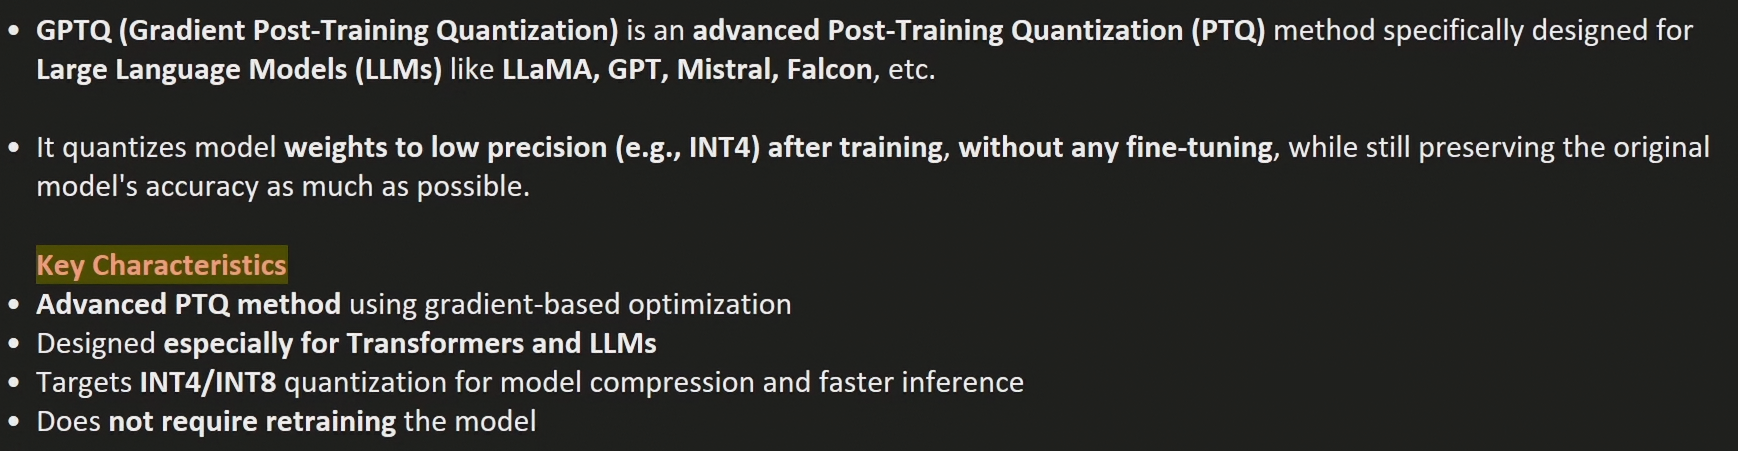

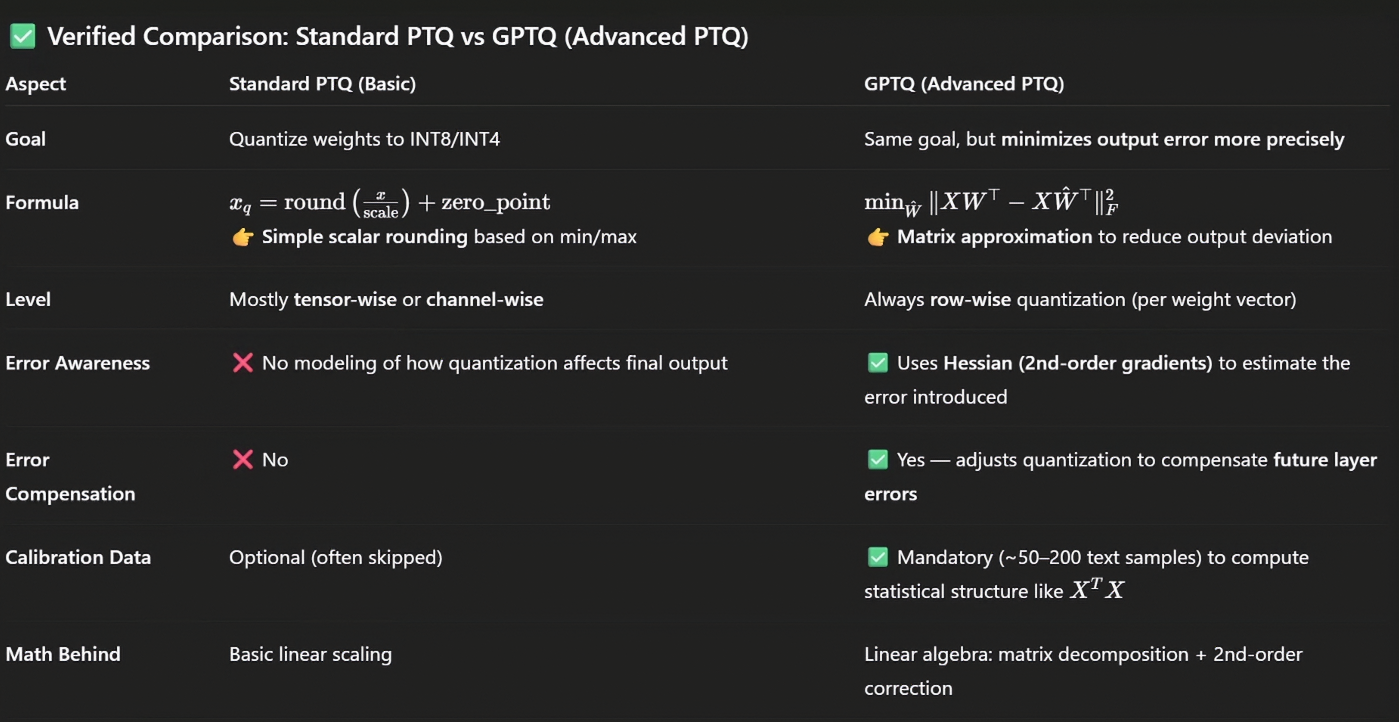


## **Activation-Aware Weight Quantization (AWQ)**

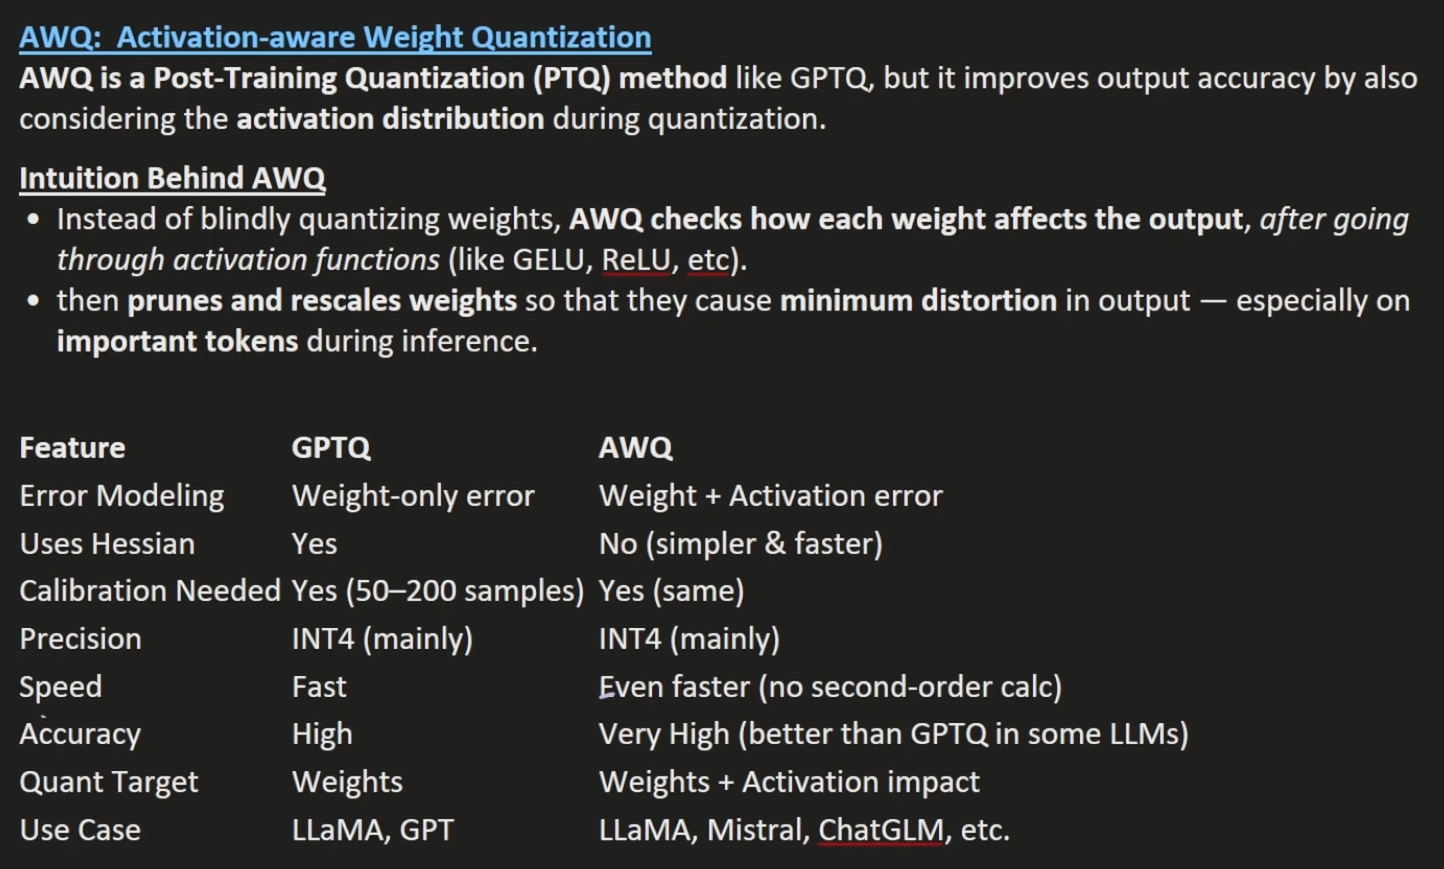

## **Georgi Gerganov's Machine Learning (GGML) Framework and Georgi Gerganov's United Format (GGUF)**

In [1]:
!apt-get install -y cmake build-essential

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
build-essential is already the newest version (12.9ubuntu3).
cmake is already the newest version (3.22.1-1ubuntu1.22.04.2).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


In [2]:
!git clone https://github.com/ggml-org/llama.cpp

Cloning into 'llama.cpp'...
remote: Enumerating objects: 77744, done.
remote: Counting objects: 100% (107/107), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 77744 (delta 69), reused 45 (delta 45), pack-reused 77637 (from 2)
Receiving objects: 100% (77744/77744), 285.84 MiB | 34.16 MiB/s, done.
Resolving deltas: 100% (56234/56234), done.


In [3]:
%cd llama.cpp

/content/llama.cpp


In [4]:
!ls -1h

AGENTS.md
AUTHORS
benches
build-xcframework.sh
ci
CLAUDE.md
cmake
CMakeLists.txt
CMakePresets.json
CODEOWNERS
common
CONTRIBUTING.md
convert_hf_to_gguf.py
convert_hf_to_gguf_update.py
convert_llama_ggml_to_gguf.py
convert_lora_to_gguf.py
docs
examples
flake.lock
flake.nix
ggml
gguf-py
grammars
include
LICENSE
licenses
Makefile
media
models
mypy.ini
pocs
poetry.lock
pyproject.toml
pyrightconfig.json
README.md
requirements
requirements.txt
scripts
SECURITY.md
src
tests
tools
vendor


In [5]:
!make -j

Makefile:6: *** Build system changed:
 The Makefile build has been replaced by CMake.

 For build instructions see:
 https://github.com/ggml-org/llama.cpp/blob/master/docs/build.md

.  Stop.


In [6]:
from huggingface_hub import snapshot_download

model_path = snapshot_download(
    repo_id="TinyLlama/TinyLlama-1.1B-Chat-v1.0",
    local_dir="tinyllama-hf",
    local_dir_use_symlinks=False
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:979: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(


Fetching 10 files:   0%|          | 0/10 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

eval_results.json:   0%|          | 0.00/566 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

In [7]:
!pip install -q mistral-common

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 66.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 102.1 MB/s eta 0:00:00


In [8]:
!python3 convert_hf_to_gguf.py ./tinyllama-hf \
  --outfile ./tinyllama-1.1b-chat.gguf

INFO:hf-to-gguf:Loading model: tinyllama-hf
INFO:hf-to-gguf:Model architecture: LlamaForCausalLM
INFO:hf-to-gguf:gguf: indexing model part 'model.safetensors'
INFO:hf-to-gguf:heuristics detected bfloat16 tensor dtype, setting --outtype bf16
INFO:gguf.gguf_writer:gguf: This GGUF file is for Little Endian only
INFO:hf-to-gguf:Exporting model...
INFO:hf-to-gguf:output.weight,               torch.bfloat16 --> BF16, shape = {2048, 32000}
INFO:hf-to-gguf:token_embd.weight,           torch.bfloat16 --> BF16, shape = {2048, 32000}
INFO:hf-to-gguf:blk.0.attn_norm.weight,      torch.bfloat16 --> F32, shape = {2048}
INFO:hf-to-gguf:blk.0.ffn_down.weight,       torch.bfloat16 --> BF16, shape = {5632, 2048}
INFO:hf-to-gguf:blk.0.ffn_gate.weight,       torch.bfloat16 --> BF16, shape = {2048, 5632}
INFO:hf-to-gguf:blk.0.ffn_up.weight,         torch.bfloat16 --> BF16, shape = {2048, 5632}
INFO:hf-to-gguf:blk.0.ffn_norm.weight,       torch.bfloat16 --> F32, shape = {2048}
INFO:hf-to-gguf:blk.0.attn_k.w

In [9]:
import os
os.getcwd()

'/content/llama.cpp'

In [10]:
!mkdir -p build

In [11]:
%cd build

/content/llama.cpp/build


In [12]:
!cmake ..

-- The C compiler identification is GNU 11.4.0
-- The CXX compiler identification is GNU 11.4.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
CMAKE_BUILD_TYPE=Release
-- Found Git: /usr/bin/git (found version "2.34.1")
-- The ASM compiler identification is GNU
-- Found assembler: /usr/bin/cc
-- Performing Test CMAKE_HAVE_LIBC_PTHREAD
-- Performing Test CMAKE_HAVE_LIBC_PTHREAD - Success
-- Found Threads: TRUE
-- Warning: ccache not found - consider installing it for faster compilation or disable this warning with GGML_CCACHE=OFF
-- CMAKE_SYSTEM_PROCESSOR: x86_64
-- GGML_SYSTEM_ARCH: x86
-- Including CPU backend
-- Found OpenMP_C: 

In [13]:
!make

[  0%] Building C object ggml/src/CMakeFiles/ggml-base.dir/ggml.c.o
[  1%] Building CXX object ggml/src/CMakeFiles/ggml-base.dir/ggml.cpp.o
[  1%] Building C object ggml/src/CMakeFiles/ggml-base.dir/ggml-alloc.c.o
[  1%] Building CXX object ggml/src/CMakeFiles/ggml-base.dir/ggml-backend.cpp.o
[  1%] Building CXX object ggml/src/CMakeFiles/ggml-base.dir/ggml-opt.cpp.o
[  1%] Building CXX object ggml/src/CMakeFiles/ggml-base.dir/ggml-threading.cpp.o
[  2%] Building C object ggml/src/CMakeFiles/ggml-base.dir/ggml-quants.c.o
[  2%] Building CXX object ggml/src/CMakeFiles/ggml-base.dir/gguf.cpp.o
[  2%] Linking CXX shared library ../../bin/libggml-base.so
[  2%] Built target ggml-base
[  2%] Building C object ggml/src/CMakeFiles/ggml-cpu.dir/ggml-cpu/ggml-cpu.c.o
[  3%] Building CXX object ggml/src/CMakeFiles/ggml-cpu.dir/ggml-cpu/ggml-cpu.cpp.o
[  3%] Building CXX object ggml/src/CMakeFiles/ggml-cpu.dir/ggml-cpu/repack.cpp.o
[  3%] Building CXX object ggml/src/CMakeFiles/ggml-cpu.dir/ggml-

In [14]:
!ls

bin		       CTestTestfile.cmake    llama.pc		   tests
CMakeCache.txt	       DartConfiguration.tcl  llama-version.cmake  tools
CMakeFiles	       examples		      Makefile		   vendor
cmake_install.cmake    ggml		      pocs
common		       license.cpp	      src
compile_commands.json  llama-config.cmake     Testing


In [15]:
os.getcwd()

'/content/llama.cpp/build'

In [16]:
!ls -lh /content/llama.cpp/

total 2.1G
-rw-r--r--  1 root root 4.4K Feb  1 13:50 AGENTS.md
-rw-r--r--  1 root root  47K Feb  1 13:50 AUTHORS
drwxr-xr-x  3 root root 4.0K Feb  1 13:50 benches
drwxr-xr-x 13 root root 4.0K Feb  1 13:51 build
-rwxr-xr-x  1 root root  22K Feb  1 13:50 build-xcframework.sh
drwxr-xr-x  2 root root 4.0K Feb  1 13:50 ci
-rw-r--r--  1 root root  106 Feb  1 13:50 CLAUDE.md
drwxr-xr-x  2 root root 4.0K Feb  1 13:50 cmake
-rw-r--r--  1 root root 9.4K Feb  1 13:50 CMakeLists.txt
-rw-r--r--  1 root root 4.5K Feb  1 13:50 CMakePresets.json
-rw-r--r--  1 root root 5.7K Feb  1 13:50 CODEOWNERS
drwxr-xr-x  3 root root 4.0K Feb  1 13:50 common
-rw-r--r--  1 root root  11K Feb  1 13:50 CONTRIBUTING.md
-rwxr-xr-x  1 root root 523K Feb  1 13:50 convert_hf_to_gguf.py
-rwxr-xr-x  1 root root  26K Feb  1 13:50 convert_hf_to_gguf_update.py
-rwxr-xr-x  1 root root  19K Feb  1 13:50 convert_llama_ggml_to_gguf.py
-rwxr-xr-x  1 root root  21K Feb  1 13:50 convert_lora_to_gguf.py
drwxr-xr-x  7 root root 4.0K Fe

In [17]:
!./bin/llama-cli -m ../tinyllama-1.1b-chat.gguf -p "What is quantization in LLMs?" -n 100


Loading model... |-\|/- 


▄▄ ▄▄
██ ██
██ ██  ▀▀█▄ ███▄███▄  ▀▀█▄    ▄████ ████▄ ████▄
██ ██ ▄█▀██ ██ ██ ██ ▄█▀██    ██    ██ ██ ██ ██
██ ██ ▀█▄██ ██ ██ ██ ▀█▄██ ██ ▀████ ████▀ ████▀
                                    ██    ██
                                    ▀▀    ▀▀

build      : b7900-2634ed207
model      : tinyllama-1.1b-chat.gguf
modalities : text

available commands:
  /exit or Ctrl+C     stop or exit
  /regen              regenerate the last response
  /clear              clear the chat history
  /read               add a text file


> What is quantization in LLMs?

|-\|/-\|/-\ Quantization in Long-Short Term Memory (LSTM) units is a process that reduces the high-frequency details and dynamics of input sequences to a lower-dimensional vector. In LSTMs, each time step is treated as a separate memory cell that can retain information from the previous time step. This memory cell is represented as an vector, and quantization involves reducing the dimensionali